# II. Spatial Autocorrelation


## Пространственная автокорреляция

**Пространственная автокорреляция** — это статистический метод, который используется для измерения степени зависимости или сходства значений переменных в пространственно распределенных объектах. Пространственная автокорреляция исследует, как значения переменной в одном месте соотносятся с значениями в соседних местах.

Если объекты, расположенные рядом друг с другом, имеют схожие значения, то это свидетельствует о высоком уровне пространственной автокорреляции. Напротив, если соседние объекты сильно различаются, то автокорреляция будет низкой.

### Виды пространственной автокорреляции:

1. **Положительная автокорреляция** — когда объекты, расположенные близко друг к другу, имеют схожие значения.
2. **Отрицательная автокорреляция** — когда объекты, расположенные рядом, имеют противоположные значения.
3. **Нулевая автокорреляция** — когда нет зависимости между значениями в соседних точках.


![Пространствннная автокорреляция](https://cdn.sanity.io/images/0xishpzy/production/ccd23afcc8667ee9c10b5e4a0c273d6dbe7779b3-680x383.png?w=2000&fit=max&auto=format)


## 0. Подготовка данных


Импортируем библиотеки


In [37]:
import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import box

import matplotlib.pyplot as plt

from pysal.explore import esda

**Загружаем данные о муниципалитетах для Краснодарского края и республики Адыгея**


In [38]:
muni = gpd.read_file('./data/krasnodar_adygea_muni.geojson')

muni.explore(tiles='cartodbpositron')

## 1. Global Moran I


**Индекс Морана** — это один из наиболее часто используемых методов для оценки пространственной автокорреляции. Этот индекс измеряет, насколько значения переменной в соседних местах схожи. Он определяется по формуле:

```{math}
I = \frac{N}{W} \cdot
\frac{\sum_i \sum_j w_{ij}(x_i - \overline{x})(x_j - \overline{x})}
{\sum_i (x_i - \overline{x})^2}
```

где:

- $N$ — количество наблюдений,
- $W$ — сумма всех весов в матрице соседства,
- $w_{ij}$ — вес (или мера близости) между объектами $i$ и $j$,
- $x_i$ и $x_j$ — значения переменной в точках $i$ и $j$,
- $\overline{x}$ — среднее значение переменной.

Значения индекса Морана интерпретируются следующим образом:

- $I > 0$ — положительная пространственная автокорреляция (соседние объекты схожи)
- $I < 0$ — отрицательная пространственная автокорреляция (соседние объекты сильно различаются)
- $I = 0$ — отсутствие пространственной автокорреляции


Наша **цель** понять, как устроен индекс Морана, поэтому сначала рассчитаем его **вручную**, последовательно выполняя все шаги, а затем (при желании) сравним результат с расчётом через готовые функции.

Сделаем это на основе данных о коэффициенте миграционного сальдо на 1000 человек за **2020 год** по муниципальным образованиям **Краснодарского края и Республики Адыгея**.

Посмотрим на рассматриваемые данные


In [39]:
muni.explore(
    column="netMigrationRate1000_2020",
    cmap="viridis",
    legend=True,
    tiles='cartodbpositron' 
)

### "Ручной" расчет индекса Морана


#### ШАГ 1. Подготовка данных


**1.1. Исключение наблюдений с пропущенными значениями**

Для корректного расчёта индекса Морана из анализа исключаются объекты, для которых отсутствуют значения анализируемого показателя (NaN).


In [40]:
muni_clean = muni.copy()
muni_clean = muni_clean[muni_clean["netMigrationRate1000_2020"].notna()].reset_index(drop=True)


**1.2. Формирование вектора значений ( x )**

Вектор ( x ) — это список значений показателя (в нашем случае — коэффициента миграционного сальдо). Порядок элементов вектора должен строго соответствовать порядку объектов в матрице пространственных весов, так как индекс Морана рассчитывается на основе попарных сравнений соседних объектов.


In [41]:
import numpy as np

x = muni_clean["netMigrationRate1000_2020"].values.astype(float)
n = len(x)

#### ШАГ 2. Расчёт среднего значения и отклонений от среднего


Сначала рассчитывается среднее значение показателя (\overline{x}).
Затем для каждого объекта определяется отклонение от среднего
((x_i - \overline{x})).

Именно эти отклонения используются в формуле индекса Морана и позволяют выявлять,
склонны ли соседние объекты иметь **похожие отклонения от среднего**
(высокие с высокими, низкие с низкими).


```{math}
I = \frac{N}{W} \cdot
\frac{\sum_i \sum_j w_{ij},\color{red}{(x_i-\overline{x})},(x_j-\overline{x})}
{\sum_i \color{red}{(x_i-\overline{x})^2}}
```


In [42]:
x_bar = x.mean()
z = x - x_bar

Величина $z_i = x_i - \overline{x}$ показывает, насколько значение в объекте $i$
выше или ниже среднего.

Индекс Морана работает с этими отклонениями, чтобы сравнивать не абсолютные значения,
а их относительное положение.


#### ШАГ 3. Матрица весов ( W )

На этом шаге задаётся, какие объекты считаются соседними.
Мы используем соседство типа Queen: объекты являются соседями, если они соприкасаются границами или углами

В предыдущем разделе, посвящённом **пространственному соседству**, мы строили матрицу с помощью инструментов библиотеки `libpysal.weights`. В данном разделе мы создадим матрицу пространственных весов **вручную**, чтобы наглядно показать логику её формирования.

**3.1. Матрица смежности (определение соседства)**

Сначала строится матрица смежности, где:

- 1 означает, что объекты являются соседями,
- 0 — что соседства нет.


In [43]:
# n — количество пространственных объектов (полигонов)
n = len(muni_clean)

# Создаём пустую матрицу весов n × n
# Пока все элементы равны 0 (соседство не задано)
W = np.zeros((n, n))

# Проходим по всем парам объектов i и j
for i in range(n):
    for j in range(n):

        # Объект не может быть соседом самому себе
        if i != j:

            # Проверяем, соприкасаются ли два полигона
            # touches = общая граница или общая вершина (Queen-соседство)
            if muni_clean.geometry.iloc[i].touches(muni_clean.geometry.iloc[j]):

                # Если объекты i и j являются соседями,
                # записываем 1 в матрицу весов
                W[i, j] = 1


**3.2. Проверка матрицы пространственных весов ( W )**

После построения матрицы пространственных весов необходимо проверить, корректно ли она сформирована. Для этого используется сумма всех элементов матрицы:


In [44]:
print("W.sum() =", W.sum())

# Доп. проверка: есть ли объекты без соседей (строка из нулей)
row_sums = W.sum(axis=1)
print("Объектов без соседей:", np.sum(row_sums == 0))

W.sum() = 218.0
Объектов без соседей: 0


Значение `W.sum()` показывает **общее количество зафиксированных соседских связей** между объектами.

- если `W.sum() = 0`, значит соседства **не были обнаружены**, и матрица построена неверно;
- положительное значение означает, что пространственные связи действительно заданы;
- главное убедиться, что матрица весов не пустая.


**3.3. Стандартизация матрицы пространственных весов**

После построения матрицы смежности матрица пространственных весов ( W ) обычно **стандартизируется по строкам**. Это означает, что сумма весов для каждого объекта ( i ) приводится к единице:

$$
w_{ij}^{*} = \frac{w_{ij}}{\sum_j w_{ij}}
$$

В результате каждый элемент матрицы показывает **относительный вклад соседа ( j )** в пространственное окружение объекта ( i ).

Это нужно так как:

- объекты могут иметь разное количество соседей;
- без стандартизации объекты с большим числом соседей оказывали бы большее влияние на результат;
- стандартизация делает вклад каждого объекта сопоставимым.


In [45]:
W_row = W.astype(float).copy()

for i in range(n):
    s = W_row[i].sum()
    if s > 0:
        W_row[i] = W_row[i] / s
    # если s == 0, оставляем строку из нулей (у объекта нет соседей)

# Проверка: суммы по строкам должны быть 1 (там, где соседи есть)
row_sums_after = W_row.sum(axis=1)
print("Мин. сумма по строкам после стандартизации:", row_sums_after[row_sums > 0].min())
print("Макс. сумма по строкам после стандартизации:", row_sums_after[row_sums > 0].max())

Мин. сумма по строкам после стандартизации: 0.9999999999999999
Макс. сумма по строкам после стандартизации: 1.0


Теперь сумма весов в каждой строке = 1 (или почти 1 - 0.9999 - в рамках погрешности)


#### ШАГ 4. Числитель: пространственно взвешенные произведения отклонений


Мы используем здесь отклонения от среднего - z рассчитанные на шаге №2

### Далее считаем числитель индекса Морана

Это именно **числитель** в полной формуле Морана:
(\sum*i \sum_j w*{ij}(x_i-\bar{x})(x_j-\bar{x})),
который удобно записать через (z_i) и (z_j).

$$
\color{#c53030}{\text{Num} = \sum_i \sum_j w_{ij}, z_i, z_j}
$$

Ниже полная формула:

$$
I =
\frac{n}{\sum_i \sum_j w_{ij}}
\cdot
\frac{
\color{#c53030}{\sum_i \sum_j w_{ij}, z_i, z_j}
}{
\sum_i z_i^2
}
$$


In [46]:
import numpy as np
# Подключаем библиотеку NumPy для работы с массивами и линейной алгеброй

x = muni_clean["netMigrationRate1000_2020"].values
# Вектор исходных значений показателя x_i (чистая миграция по муниципалитетам)

x_mean = x.mean()
# Вычисляем среднее значение показателя: \bar{x}

z = x - x_mean
# Центрируем данные:
# z_i = x_i - \bar{x}
# Эти отклонения используются в числителе и знаменателе формулы Морана

numerator = z @ W_row @ z
# Вычисляем числитель индекса Морана в матричной форме:
# \sum_i \sum_j w_{ij} z_i z_j
# Здесь:
# z        — вектор отклонений,
# W_row    — стандартизированная по строкам матрица пространственных весов,
# @        — операция матричного умножения

print("Числитель:", numerator)


Числитель: 1167.7349303918368


> `z @ W_row @ z` — это компактная запись двойной суммы по всем парам (i, j).

numerator можно записать и по-другому:


In [47]:
numerator = 0
# Инициализируем числитель индекса Морана
# Здесь будет накапливаться значение двойной суммы

for i in range(n):
    # Внешний цикл по объектам i
    # Соответствует первой сумме: \sum_i

    for j in range(n):
        # Внутренний цикл по объектам j
        # Соответствует второй сумме: \sum_j

        numerator += W_row[i, j] * z[i] * z[j]
        # Добавляем вклад пары объектов (i, j) в числитель:
        # w_{ij} · z_i · z_j
        # Это элемент выражения:
        # \sum_i \sum_j w_{ij} z_i z_j

#### ШАГ 5. Знаменатель: сумма квадратов отклонений

В
На этом шаге вычисляется **знаменатель индекса Морана**, который отвечает за нормировку числителя и отражает общую вариацию анализируемого показателя.

$$
\color{#2f855a}{\text{Den} = \sum_i z_i^2}
$$

Здесь:

- (z_i = x_i - \overline{x}) — отклонение значения показателя от среднего;
- сумма (\sum_i z_i^2) эквивалентна дисперсионному компоненту и совпадает со **знаменателем** в полной формуле индекса Морана.

Ниже полная формула:

$$
I =
\frac{n}{\sum_i \sum_j w_{ij}}
\cdot
\frac{
\sum_i \sum_j w_{ij}, z_i, z_j
}{
\color{#2f855a}{\sum_i z_i^2}
}
$$


In [48]:
denominator = np.sum(z**2)
print("Знаменатель:", denominator)

Знаменатель: 4050.6924200000003


#### ШАГ 6. Нормирующий множитель (N/W) и итоговый индекс

На этом шаге все ранее вычисленные компоненты объединяются в итоговую формулу индекса Морана.
Нормирующий множитель учитывает размер выборки и суммарную интенсивность пространственных связей.

Сначала вычисляется нормирующий множитель:

$$
\color{#805ad5}{\text{Norm} = \frac{n}{\sum_i \sum_j w_{ij}}}
$$

где:

- (n) — число пространственных объектов;
- (\sum*i \sum_j w*{ij}) — сумма всех элементов матрицы пространственных весов
  (для матрицы, стандартизированной по строкам, эта сумма равна (n)).

Нормирующий множитель нужен для того, чтобы **индекс Морана не зависел от размера набора данных и способа задания соседства**.

Теперь можно вычислить сам индекс Морана:

$$
I = \color{#805ad5}{\text{Norm}}
\cdot
\frac{\text{Num}}{\text{Den}}
$$

где:

- (\text{Num} = \sum*i \sum_j w*{ij} z_i z_j) — числитель (ШАГ 4);
- (\text{Den} = \sum_i z_i^2) — знаменатель (ШАГ 5).

Формула Индекса Морана целиком:

$$
I =
\color{#805ad5}{\frac{n}{\sum_i \sum_j w_{ij}}}
\cdot
\frac{
\sum_i \sum_j w_{ij}, z_i, z_j
}{
\sum_i z_i^2
}
$$


In [49]:
N = len(x)
W_sum = W_row.sum()

I = (N / W_sum) * (numerator / denominator)

print("N:", N)
print("W (сумма весов):", W_sum)
print("Moran's I:", I)

N: 49
W (сумма весов): 49.0
Moran's I: 0.2882803257601664


### Расчёт индекса Морана (Moran I) с библиотекой esda


Построим матрицу соседства


In [50]:
from libpysal.weights import Queen

muni_clean = muni_clean.reset_index(drop=True) # сбросим индексы, чтобы потом использовать их как id
w = Queen.from_dataframe(muni_clean, ids=muni_clean.index.tolist())

Рассчитаем индекс Морана


In [51]:
# Рассчитываем индекс Морана для значений кожффициента миграции
# w - матрица весов
moran_pop = esda.Moran(muni_clean['netMigrationRate1000_2020'], w)

Смотрим на результат


In [52]:
print(f"Moran's I: {moran_pop.I}")
print(f"p-value: {moran_pop.p_sim}")

Moran's I: 0.2882803257601664
p-value: 0.003


Значение индекса Морана составляет **( I = 0.29 )**, что указывает на **положительную пространственную автокорреляцию**. Это означает, что муниципалитеты с похожими значениями коэффициента миграционного сальдо на 1000 человек, как правило, располагаются рядом друг с другом.

Значение **p-value = 0.001** свидетельствует о том, что обнаруженная пространственная автокорреляция является **статистически значимой**. Вероятность получить такое или более экстремальное значение индекса Морана случайным образом составляет менее 0.1%.

Глобальный индекс Морана подтверждает наличие пространственной автокорреляции в целом по территории, однако не показывает её пространственную локализацию. Для выявления конкретных кластеров далее используется локальный индекс Морана (LISA).


## 2. Local Morans's I (LISA)


**Local Moran’s I (LISA — Local Indicators of Spatial Association)** — это показатель локальной пространственной автокорреляции.
Он показывает **не общую (глобальную)** зависимость, а то, **как каждая отдельная ячейка связана со своими соседями**.

Local Moran помогает обнаружить:

- **локальные кластеры**:
  - **HH** — высокая величина окружена высокими
  - **LL** — низкая величина окружена низкими

- **пространственные аномалии**:
  - **HL** — высокая величина среди низких
  - **LH** — низкая величина среди высоких

**Формула Local Moran’s I**

```{math}
I_i = z_i \sum_{j} w_{ij} z_j
```

Где:

- $I_i$ — локальный индекс Морана для объекта (i);
- $z_i = \dfrac{x_i - \bar{x}}{s}$ — стандартизированное значение переменной;
- $w\_{ij}$ — вес из матрицы пространственных весов
  (1 — если (j) является соседом объекта (i), 0 — иначе);
- сумма берётся по всем соседям $j$;
- $z_j$ — стандартизированные значения соседних объектов.

Как интерпретировать Local Moran’s I:

- $I_i > 0$
  объект похож на своих соседей
  (пространственный кластер **HH** или **LL**);

- $I_i < 0$
  объект сильно отличается от соседей
  (пространственная аномалия **HL** или **LH**).


По аналогии с глобальным индексом Морана, мы сначала посчитаем LISA вручную, а затем с помощью функции из библиотеки esda.


### LISA по шагам


> Многие из этих шагов уже выполнялись выше при расчёте глобального индекса Морана.
> Здесь мы повторяем их, чтобы последовательно и полностью показать процесс расчёта локальных индексов пространственной автокорреляции (LISA)


#### ШАГ 1. Подготовка данных

**1.1. Исключение наблюдений с пропущенными значениями**

Для корректного расчёта LISA - из анализа исключаются объекты, для которых отсутствуют значения анализируемого показателя (NaN).


In [53]:
muni_clean = muni.dropna(subset=["netMigrationRate1000_2020"]).copy()

**1.2. Формирование вектора значений ( x )**

Вектор ( x ) — это список значений показателя (в нашем случае — коэффициента миграционного сальдо). Порядок элементов вектора должен строго соответствовать порядку объектов в матрице пространственных весов


In [54]:
x = muni_clean["netMigrationRate1000_2020"].values

#### ШАГ 2. Центрирование и стандартизация (получаем (z))

Сначала рассчитывается среднее значение показателя $\overline{x}$.
Затем для каждого объекта определяется отклонение от среднего $(x_i - \overline{x})$.

Для расчёта **локального индекса Морана (LISA)** эти отклонения обычно дополнительно **стандартизируют**, то есть делят на стандартное отклонение (s). В результате получаем _z-score_:

$$
z_i = \frac{x_i - \overline{x}}{s}
$$

где (s) — стандартное отклонение показателя по всем объектам.

Стандартное отклонение вычисляется по формуле:

$$
s = \sqrt{\frac{1}{n} \sum_i (x_i - \overline{x})^2}
$$

где:

- $n$ — число пространственных объектов;
- $\overline{x}$ — среднее значение показателя.

Стандартизация нужна, чтобы привести значения к общей шкале:

- $z_i > 0$ означает, что значение в объекте выше среднего;
- $z_i < 0$ — ниже среднего;
- модуль $|z_i|$ показывает, насколько сильно объект отклоняется от среднего.


In [55]:
# Среднее значение показателя по всем объектам ( x̄ )
x_mean = x.mean()

# Стандартное отклонение показателя ( s )
# ddof=1 — используем выборочное стандартное отклонение
x_std = x.std(ddof=1)

# Стандартизованные отклонения (z-score):
# показывают, насколько значение в объекте выше или ниже среднего
z = (x - x_mean) / x_std


#### ШАГ 3. Матрица весов ( W )

На этом шаге задаётся, какие объекты считаются соседними.
Мы используем соседство типа Queen: объекты являются соседями, если они соприкасаются границами или углами

В предыдущем разделе, посвящённом **пространственному соседству**, мы строили матрицу с помощью инструментов библиотеки `libpysal.weights`. В данном разделе мы создадим матрицу пространственных весов **вручную**, чтобы наглядно показать логику её формирования.

**3.1. Матрица смежности (определение соседства)**

Сначала строится матрица смежности, где:

- 1 означает, что объекты являются соседями,
- 0 — что соседства нет.


In [56]:
# n — количество пространственных объектов (полигонов)
n = len(muni_clean)

# Создаём пустую матрицу весов n × n
# Пока все элементы равны 0 (соседство не задано)
W = np.zeros((n, n))

# Проходим по всем парам объектов i и j
for i in range(n):
    for j in range(n):

        # Объект не может быть соседом самому себе
        if i != j:

            # Проверяем, соприкасаются ли два полигона
            # touches = общая граница или общая вершина (Queen-соседство)
            if muni_clean.geometry.iloc[i].touches(muni_clean.geometry.iloc[j]):

                # Если объекты i и j являются соседями,
                # записываем 1 в матрицу весов
                W[i, j] = 1


**3.2. Проверка матрицы пространственных весов ( W )**

После построения матрицы пространственных весов необходимо проверить, корректно ли она сформирована. Для этого используется сумма всех элементов матрицы:


In [57]:
print("W.sum() =", W.sum())

# Доп. проверка: есть ли объекты без соседей (строка из нулей)
row_sums = W.sum(axis=1)
print("Объектов без соседей:", np.sum(row_sums == 0))

W.sum() = 218.0
Объектов без соседей: 0


Значение `W.sum()` показывает **общее количество зафиксированных соседских связей** между объектами.

- если `W.sum() = 0`, значит соседства **не были обнаружены**, и матрица построена неверно;
- положительное значение означает, что пространственные связи действительно заданы;
- главное убедиться, что матрица весов не пустая.


**3.3. Стандартизация матрицы пространственных весов**

После построения матрицы смежности матрица пространственных весов $W$ обычно **стандартизируется по строкам**. Это означает, что сумма весов для каждого объекта ( i ) приводится к единице:

$$
w_{ij}^{*} = \frac{w_{ij}}{\sum_j w_{ij}}
$$

В результате каждый элемент матрицы показывает **относительный вклад соседа $j$** в пространственное окружение объекта $i$.

Это нужно так как:

- объекты могут иметь разное количество соседей;
- без стандартизации объекты с большим числом соседей оказывали бы большее влияние на результат;
- стандартизация делает вклад каждого объекта сопоставимым.


In [58]:
W_row = W.astype(float).copy()

for i in range(n):
    s = W_row[i].sum()
    if s > 0:
        W_row[i] = W_row[i] / s
    # если s == 0, оставляем строку из нулей (у объекта нет соседей)

# Проверка: суммы по строкам должны быть 1 (там, где соседи есть)
row_sums_after = W_row.sum(axis=1)
print("Мин. сумма по строкам после стандартизации:", row_sums_after[row_sums > 0].min())
print("Макс. сумма по строкам после стандартизации:", row_sums_after[row_sums > 0].max())

Мин. сумма по строкам после стандартизации: 0.9999999999999999
Макс. сумма по строкам после стандартизации: 1.0


#### ШАГ 4. Пространственно взвешенное окружение (Wz)

После построения матрицы пространственных весов (W) и получения стандартизированных значений $z_i$ необходимо определить, **какие значения имеют соседи каждого объекта**.

Для этого вычисляется пространственно взвешенная сумма стандартизированных значений соседних объектов:

$$
(Wz)*i = \sum_j w*{ij}, z_j
$$

Здесь:

- $w_{ij}$ — вес связи между объектами $i$ и $j$;
- $z_j$ — стандартизированное значение показателя у соседа $j$.

Полная формула локального индекса Морана имеет вид:

$$
I_i = z_i \sum_j w_{ij}, z_j
$$

На этом шаге вычисляется **вторая часть формулы** —
$\sum_j w_{ij} z_j$, то есть **пространственно взвешенное окружение объекта $i$**.

Величина $(Wz)_i$ показывает, является ли окружение объекта $i$:

- **положительным** $((Wz)_i > 0)$ — соседи в среднем имеют значения выше среднего;
- **отрицательным** $((Wz)_i < 0)$ — соседи в среднем имеют значения ниже среднего.

Таким образом, этот шаг описывает **пространственный контекст**, в котором находится объект, и подготавливает данные для расчёта локального индекса Морана.


In [59]:
# Пространственно взвешенные значения соседей
wz = W_row @ z

#### ШАГ 5. Расчёт локального индекса Морана (I_i)

Локальный индекс Морана для каждого объекта рассчитывается как произведение его собственного стандартизированного значения и среднего значения его соседей:

$$
I_i = z_i \cdot (Wz)_i
$$


In [60]:
# Локальные значения Moran's I (LISA)
Ii = z * wz

Смысл этой величины:

- большие положительные значения (I_i) указывают на **локальную кластеризацию**;
- отрицательные значения (I_i) указывают на **пространственные выбросы**.


> LISA сравнивает значение показателя в каждом объекте с усреднёнными значениями у его соседей и позволяет выявить локальные кластеры и пространственные выбросы, которые не видны при использовании глобальных показателей.


### Расчёт LISA с библиотекой esda


In [61]:
# Рассчитываем локальный индекс Морана для ДТП
local_moran = esda.Moran_Local(muni_clean['netMigrationRate1000_2020'], w)

# Получаем локальные значения индекса Морана для каждого региона
local_moran_values = local_moran.Is  # Это значения индекса Морана для каждого элемента
print(local_moran_values)


[-0.05806776 -0.31533015  0.00672817  0.14250806 -0.10705746  0.4596399
 -0.03499515 -0.00759866 -0.39282979  0.06622086 -0.06038852  0.10792555
 -0.01352756  0.03852756 -0.04062    -0.05527756  0.10928648  0.13254698
  0.25055711  0.30766924  0.04407877  0.1971904   0.48055856  0.06927641
  0.42649241 -0.02404821  0.30983262 -0.35649215 -0.02932321  0.10194689
  0.28981067  0.01244329  0.44114297  0.0242414   0.49135408 -0.61436083
  0.27124158  0.22159067 -0.06230919  0.85549596  1.26442503  1.73900227
  0.3154164   0.02331998  1.45441482  3.47022595  1.35891774 -0.02576835
  0.55142142]


#### Построим LISA Cluster Map


В local_moran.q мы можем узнать к какому кластеру (HH, LL, HL, LH) попадает каждая из ячеек


In [62]:
local_moran.q

array([4, 2, 1, 3, 2, 3, 4, 2, 4, 3, 4, 3, 4, 3, 2, 4, 3, 1, 3, 3, 3, 3,
       3, 3, 1, 2, 3, 4, 4, 3, 1, 3, 3, 1, 3, 2, 3, 3, 2, 1, 1, 1, 1, 3,
       1, 1, 1, 4, 3])

**LISA Cluster Map** — это карта локальных кластеров индекса Морана, которая показывает, где именно в пространстве формируются значимые группы высоких или низких значений. В отличие от глобального индекса Морана, который оценивает пространственную зависимость в целом, LISA анализируется отдельно для каждой ячейки и её соседей.

Карта выделяет четыре типа зон: **HH** (высокие значения среди высоких), **LL** (низкие среди низких), **HL** (высокие среди низких — аномальные пики) и **LH** (низкие среди высоких )


In [63]:
# категории LISA в правильном порядке
cluster_labels = np.array(['Not significant', 'HH', 'LH', 'LL', 'HL'])
labels = cluster_labels[local_moran.q]

muni_clean['lisa_cluster'] = labels

# Цвета для категорий
colors = {
    'HH': 'red',
    'LL': 'blue',
    'LH': 'lightblue',
    'HL': 'pink',
    'Not significant': 'lightgrey'
}

muni_clean.explore(
    column='lisa_cluster',
    categories=list(colors.keys()),   # список категорий
    color=[colors[c] for c in colors], # список цветов в том же порядке
    categorical=True,
    legend=True,
    tiles='cartodbpositron'
)


## 3. Bivariate Moran


Давайте посмотрим коррелируют ли значения плотности населения с коэффициентом прибытия


### Корреляция Пирсона


Сначала рассмотрим непространственную корреляцию


In [64]:
muni_clean['netMigrationRate1000_2020'].head()

0    6.102
1   -0.501
2    4.375
3    1.164
4    0.979
Name: netMigrationRate1000_2020, dtype: float64

Корреляция Пирсона между коэффициентом прибытия и коэффициентом убытия: 0.877


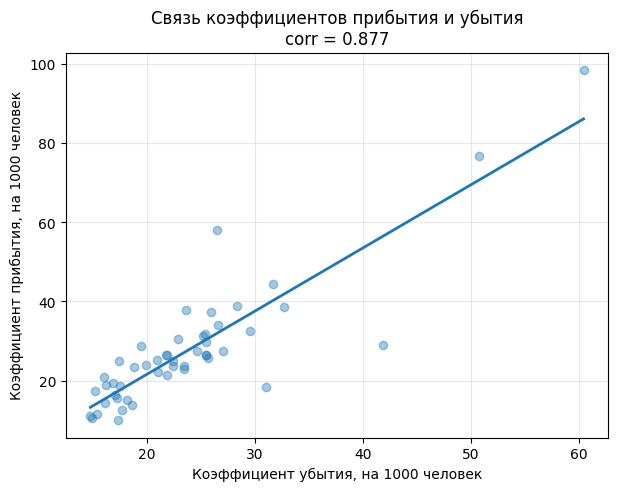

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Берём две переменные из данных
acc = muni_clean['inMigrationRate1000_2020']    # коэффициент прибытия
out = muni_clean['outMigrationRate1000_2020']   # коэффициент убытия

# Коэффициент корреляции Пирсона
corr = np.corrcoef(acc, out)[0, 1]
print(
    "Корреляция Пирсона между коэффициентом прибытия "
    f"и коэффициентом убытия: {corr:.3f}"
)

# Scatterplot с линией регрессии
plt.figure(figsize=(7, 5))
plt.scatter(out, acc, alpha=0.4)

# Линия тренда
b, a = np.polyfit(out, acc, 1)
x_line = np.linspace(out.min(), out.max(), 100)
plt.plot(x_line, a + b * x_line, linewidth=2)

plt.xlabel("Коэффициент убытия, на 1000 человек")
plt.ylabel("Коэффициент прибытия, на 1000 человек")
plt.title(
    "Связь коэффициентов прибытия и убытия\n"
    f"corr = {corr:.3f}"
)
plt.grid(alpha=0.3)
plt.show()


### Bivariate Moran - пространственная корреляция


Bivariate Moran’s I — это показатель, который измеряет, насколько значение одной переменной в ячейке связано со значениями другой переменной в соседних ячейках


In [66]:
from pysal.explore import esda

# X — коэффициент прибытия (в самом муниципалитете)
# Y — коэффициент убытия (у соседей)
x = muni_clean['netMigrationRate1000_2020'].values
y = muni_clean['outMigrationRate1000_2020'].values

moran_bv = esda.Moran_BV(x, y, w, permutations=999)

print(
    "Bivariate Moran's I "
    "(коэффициент прибытия ~ коэффициент убытия у соседей): "
    f"{moran_bv.I:.3f}"
)
print(f"p-value: {moran_bv.p_sim:.3f}")

Bivariate Moran's I (коэффициент прибытия ~ коэффициент убытия у соседей): 0.228
p-value: 0.006


## 4. Итог


В этом разделе мы рассмотрели основные подходы к анализу **пространственной автокорреляции**.

- **Глобальный индекс Морана** используется для выявления пространственной структуры одного показателя.
- **Локальные индексы Морана (LISA)** позволяют определить, где именно формируются кластеры и пространственные выбросы.
- **Bivariate индекс Морана** применяется для анализа пространственной связи между **двумя различными показателями**, когда значение одной переменной сопоставляется с окружением другой.
- Все варианты индекса Морана опираются на матрицу пространственных весов, выбор которой влияет на результат анализа.
